# Unsupervised Learning Analysis of Patient Vital Signs

This notebook explores patterns and relationships in patient vital sign data from the MIMIC-IV database using unsupervised learning techniques.

## Purpose
- Identify natural groupings and patterns in patient vital signs
- Discover potential patient subgroups based on vital sign characteristics
- Explore temporal trends in vital sign measurements

## Approach
1. Data preprocessing and aggregation of vital signs (heart rate, respiratory rate, blood pressure, temperature, SpO2)
2. Dimensionality reduction using UMAP for visualization
3. Clustering analysis using K-means and DBSCAN
4. Evaluation of cluster quality and interpretation of results

The analysis focuses on a 5% sample of patients to demonstrate the methodology while maintaining computational efficiency.


In [5]:
# Import required libraries and utilities
# Data handling & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import umap.umap_ as umap
from tqdm import tqdm

# Scikit-learn components
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed

# Custom utilities
from setup_utils import (setup_db_connection, plr, save_intermediate_data,
                            plot_histogram, plot_scatter, plot_line, plot_correlation_matrix)

# Connect to DB and load data
engine = setup_db_connection()
vdf = pd.read_sql_query("""select * from mimiciv.mimiciv_derived.vitalsign""", engine)


In [7]:
"""
Data Preprocessing Pipeline
------------------------
1. Extract and transform vital signs data
2. Perform temporal aggregation
3. Sample dataset for computational efficiency
4. Remove statistical outliers
5. Scale features for ML algorithms

Key preprocessing steps:
- Daily aggregation reduces temporal noise
- 5% sampling maintains statistical significance
- IQR-based outlier removal (1.5 * IQR threshold)
- StandardScaler ensures algorithm compatibility
"""

# Define key columns
cols_vitals = ['heart_rate', 'resp_rate', 'mbp', 'temperature', 'spo2']
cols_to_use_time = ['charttime', 'subject_id'] + cols_vitals

# Temporal processing and aggregation
df = vdf[cols_to_use_time].copy()
df['charttime'] = pd.to_datetime(df['charttime'], errors='coerce')
df['charttime'] = df['charttime'].dt.date
df = df.groupby(['subject_id', 'charttime'], as_index=False)[cols_vitals].mean()

# Strategic sampling and outlier removal
unique_subjects = df['subject_id'].unique()
sample_size = int(len(unique_subjects)*0.05)
np.random.seed(42)
sampled_subjects = np.random.choice(unique_subjects, size=sample_size, replace=False)
df = df[df['subject_id'].isin(sampled_subjects)]

# Sample 5% of subjects for demonstration
# - Earlier versions of this notebook sampled 100% of subjects, which severely impacted performance
unique_subjects = df['subject_id'].unique()
sample_size = int(len(unique_subjects)*0.05)
np.random.seed(42)
sampled_subjects = np.random.choice(unique_subjects, size=sample_size, replace=False)
df = df[df['subject_id'].isin(sampled_subjects)]
df = df.dropna()

# IQR Outlier Removal (post-sampling)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[cols_vitals])

In [8]:
"""
Dimensionality Reduction
----------------------
1. Apply UMAP for non-linear dimensionality reduction
2. Configure UMAP parameters for optimal projection
3. Generate 2D representation of vital signs
4. Prepare visualization coordinates

UMAP advantages:
- Preserves both local and global structure
- Handles non-linear relationships effectively
- Provides meaningful clusters for visualization
"""

# UMAP configuration and transformation
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

umap_embedding = umap_reducer.fit_transform(scaled_data)
df['umap_x'] = umap_embedding[:, 0]
df['umap_y'] = umap_embedding[:, 1]

c:\Users\steve\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
# Model Pipeline

# UMAP
# - Visualize high-dimensional vital signs data in 2D space
# - Parameters tuned for balance between local (n_neighbors=5) and global structure (min_dist=0.05)
reducer = umap.UMAP(n_neighbors=5, min_dist=0.05, random_state=42, n_jobs=1)
embedding = reducer.fit_transform(scaled_data)
df['umap_x'] = embedding[:, 0]
df['umap_y'] = embedding[:, 1]

# KMeans
# - Partitional clustering to identify distinct patient groups based on vital signs
# - Uses 3 clusters to capture major patterns while avoiding over-segmentation
# - Outlier detection using distance to cluster centroids (95th percentile threshold)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
df['kmeans_cluster'] = kmeans_labels

distances = kmeans.transform(scaled_data)
df['distance_to_center'] = [distances[i, lbl] for i, lbl in enumerate(kmeans_labels)]
threshold = np.percentile(df['distance_to_center'], 95)
df['kmeans_outlier'] = df['distance_to_center'] > threshold

# DBSCAN
# - Density-based clustering to find clusters of arbitrary shape
# - Applied to both raw scaled data and UMAP-reduced data for comparison
dbscan = DBSCAN(eps=0.50, min_samples=10)
db_labels = dbscan.fit_predict(scaled_data)
df['dbscan_label'] = db_labels
df['dbscan_outlier'] = (db_labels == -1)

# DBSCAN on UMAP (to compare with KMeans)
dbscan_umap = DBSCAN(eps=0.50, min_samples=10)
umap_labels = dbscan_umap.fit_predict(embedding)
df['umap_dbscan_label'] = umap_labels
df['umap_dbscan_outlier'] = (umap_labels == -1)


In [13]:
# Function to apply UMAP + KMeans and compute silhouette score
def evaluate_umap_kmeans(data, umap_params, k):
    # Apply UMAP
    umap_model = umap.UMAP(n_neighbors=umap_params['n_neighbors'],
                           min_dist=umap_params['min_dist'],
                           random_state=42)
    reduced_data = umap_model.fit_transform(data)

    # Apply KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_data)

    # Evaluate clustering using Silhouette Score
    score = silhouette_score(reduced_data, labels)
    return {'umap_params': umap_params, 'k': k, 'silhouette_score': score}

# Parallelized optimization function
def optimize_umap_kmeans_parallel(data, umap_params_grid, k_values, n_jobs=-1):
    param_combinations = list(ParameterGrid(umap_params_grid))
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_umap_kmeans)(data, umap_params, k)
        for umap_params in param_combinations
        for k in k_values
    )
    return pd.DataFrame(results)

# Define UMAP parameter grid and KMeans range
umap_param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6],
    'min_dist': [0.05, 0.1, 0.25, 0.5]
}
k_values = range(2, 10)


# Optimize UMAP + KMeans
results_df = optimize_umap_kmeans_parallel(scaled_data, umap_param_grid, k_values)

# Find the best configuration
best_result = results_df.loc[results_df['silhouette_score'].idxmax()]
print("Best Parameters:", best_result['umap_params'])
print("Best k:", best_result['k'])
print("Best Silhouette Score:", best_result['silhouette_score'])

Best Parameters: {'min_dist': 0.05, 'n_neighbors': 6}
Best k: 9
Best Silhouette Score: 0.47178894


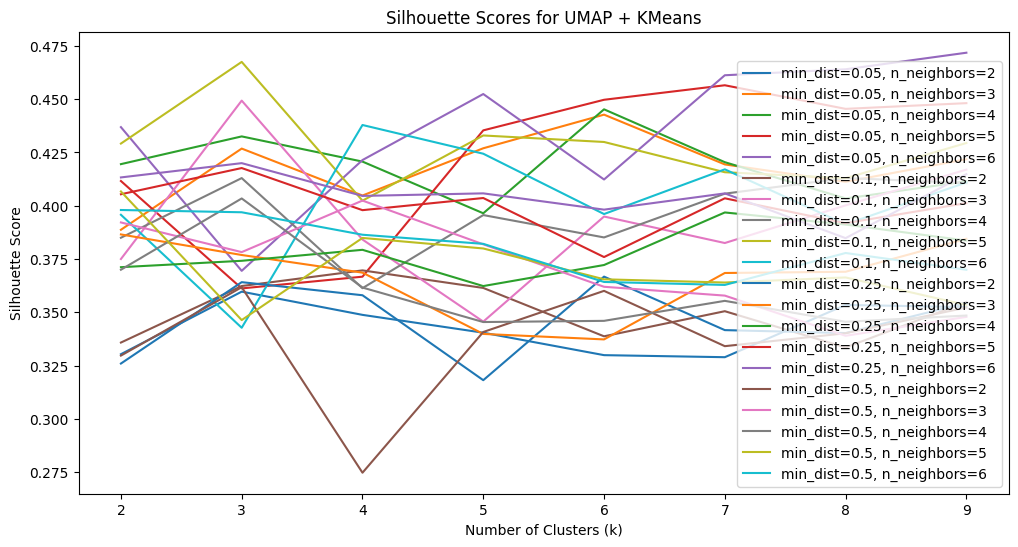

In [14]:
# Silhouette Scoring and Visualization
# The silhouette score measures how similar a point is to its own cluster compared to other clusters
# Higher silhouette scores (closer to 1) indicate better-defined clusters

# Plot Silhouette Scores
plt.figure(figsize=(12, 6))
for min_dist in umap_param_grid['min_dist']:
    subset = results_df[results_df['umap_params'].apply(lambda x: x['min_dist'] == min_dist)]
    for n_neighbors in umap_param_grid['n_neighbors']:
        sub_subset = subset[subset['umap_params'].apply(lambda x: x['n_neighbors'] == n_neighbors)]
        plt.plot(sub_subset['k'], sub_subset['silhouette_score'],
                 label=f"min_dist={min_dist}, n_neighbors={n_neighbors}")

plt.title("Silhouette Scores for UMAP + KMeans")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()


In [15]:
# Categorize Outliers

"""
Categorizes a data point based on which outlier detection methods flagged it.

Args:
    row: A pandas Series containing boolean flags for each outlier detection method:
        - kmeans_outlier: Whether KMeans identified this as an outlier
        - dbscan_outlier: Whether DBSCAN identified this as an outlier  
        - umap_dbscan_outlier: Whether UMAP+DBSCAN identified this as an outlier

Returns:
    str: A string indicating which methods identified the point as an outlier,
         joined by '&' (e.g. 'KMeans & DBSCAN'). Returns 'No Outlier' if no
         methods flagged the point.
"""
def outlier_category(row):
    km = row['kmeans_outlier']
    db = row['dbscan_outlier']
    ud = row['umap_dbscan_outlier']
    outlier_methods = []
    if km:
        outlier_methods.append('KMeans')
    if db:
        outlier_methods.append('DBSCAN')
    if ud:
        outlier_methods.append('UMAP_DBSCAN')
    if len(outlier_methods) == 0:
        return 'No Outlier'
    return ' & '.join(outlier_methods)

# Apply the outlier_category function to each row in the dataframe
df['outlier_combination'] = df.apply(outlier_category, axis=1)


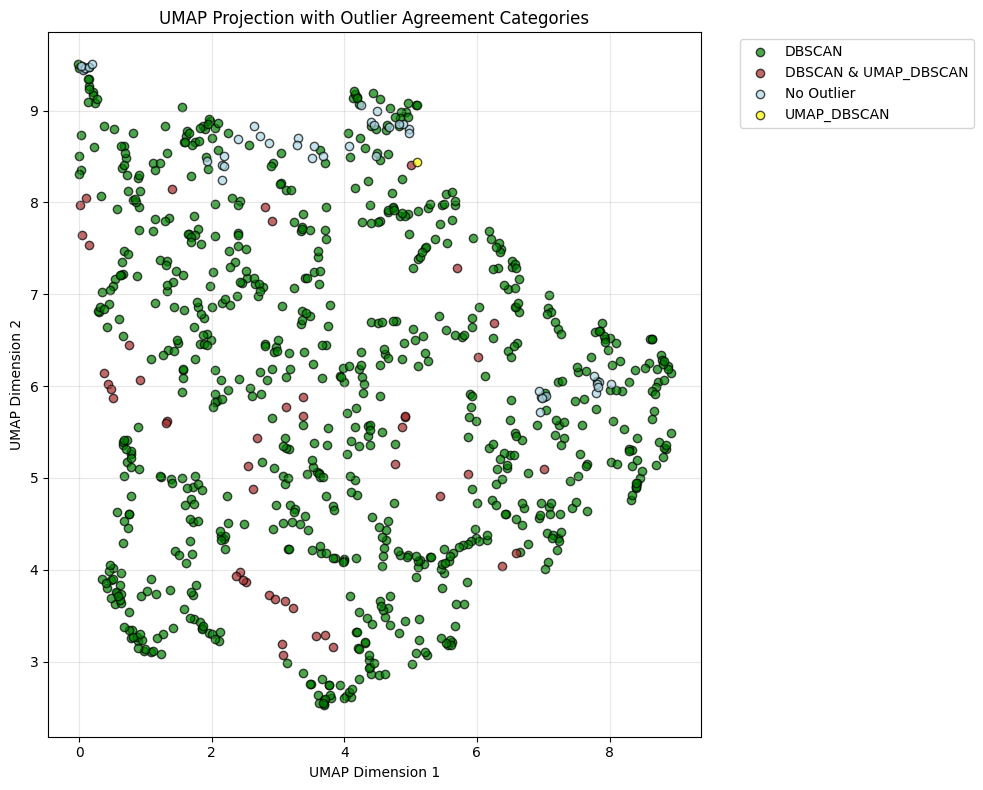


Outlier Detection Summary:
-------------------------
DBSCAN: 781 points (89.6%)
DBSCAN & UMAP_DBSCAN: 47 points (5.4%)
No Outlier: 43 points (4.9%)
UMAP_DBSCAN: 1 points (0.1%)


In [17]:
"""
Outlier Analysis and Visualization
------------------------------
1. Combine results from multiple detection methods
2. Create outlier agreement categories
3. Visualize overlapping detections
4. Generate comprehensive outlier map

Methods compared:
- KMeans: Distance-based outliers
- DBSCAN: Density-based outliers
- UMAP-DBSCAN: Manifold-based outliers
"""

def get_outlier_combination(kmeans_flag, dbscan_flag, umap_dbscan_flag):
    """
    Categorize data points based on which methods flagged them as outliers.
    
    Args:
        kmeans_flag (bool): KMeans outlier flag
        dbscan_flag (bool): DBSCAN outlier flag
        umap_dbscan_flag (bool): UMAP+DBSCAN outlier flag
    
    Returns:
        str: Category indicating which methods identified the point as an outlier
    """
    methods = []
    if kmeans_flag:
        methods.append('KMeans')
    if dbscan_flag:
        methods.append('DBSCAN')
    if umap_dbscan_flag:
        methods.append('UMAP_DBSCAN')
    
    return ' & '.join(methods) if methods else 'No Outlier'

# Generate outlier combination categories
df['outlier_combination'] = df.apply(
    lambda row: get_outlier_combination(
        row['kmeans_outlier'],
        row['dbscan_outlier'],
        row['umap_dbscan_outlier']
    ), 
    axis=1
)

# Visualization configuration
color_map = {
    'No Outlier': 'lightblue',
    'KMeans': 'orange',
    'DBSCAN': 'green',
    'UMAP_DBSCAN': 'yellow',
    'KMeans & DBSCAN': 'pink',
    'KMeans & UMAP_DBSCAN': 'purple',
    'DBSCAN & UMAP_DBSCAN': 'brown',
    'KMeans & DBSCAN & UMAP_DBSCAN': 'red'
}

# Create visualization
plt.figure(figsize=(10,8))
for cat in df['outlier_combination'].unique():
    cat_points = df[df['outlier_combination'] == cat]
    plt.scatter(cat_points['umap_x'], 
               cat_points['umap_y'],
               color=color_map[cat],
               alpha=0.7,
               edgecolor='black',
               label=cat)

plt.title('UMAP Projection with Outlier Agreement Categories')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nOutlier Detection Summary:")
print("-" * 25)
for cat in sorted(df['outlier_combination'].unique()):
    count = len(df[df['outlier_combination'] == cat])
    percentage = (count / len(df)) * 100
    print(f"{cat}: {count} points ({percentage:.1f}%)")

# Unsupervised Analysis

## Process Summary
- Applied multiple unsupervised outlier detection methods:
  - KMeans clustering
  - DBSCAN clustering
  - UMAP dimensionality reduction + DBSCAN
- Visualized agreement between methods using UMAP projection
- Created an outlier categorization, showing where methods agree/disagree
- Used color coding to distinguish between single method detections and overlapping detections

## Potential Improvements & Pitfalls
- Current approach uses fixed hyperparameters - could implement parameter tuning
- UMAP projection may not perfectly preserve high-dimensional relationships
- No validation metrics for outlier detection accuracy (inherent challenge with unsupervised learning)
- Methods may be sensitive to data scaling/normalization choices
- Current visualization are cluttered with large datasets

## Next Steps
1. Validate findings:
   - Cross-reference detected outliers with domain knowledge
   - Compare results with supervised model results
   - Various scope and ensemble methods could improve quality at scale

2. Enhance methodology:
   - Implement parameter optimization
   - Add additional outlier detection methods (e.g., Isolation Forest, LOF)
   - Explore feature importance in outlier detection

3. Improve visualization:
   - Add interactive plotting capabilities (e.g. plotly, frontend web application)
   - Views focusing on specific detection methods
   - Include summary statistics for each outlier category

4. Production considerations:
   - Streamline pipeline for new data processing
   - Add model persistence capabilities (e.g. joblib, pickle)
   - Implement performance optimization for larger datasets


In [8]:
# Save intermediate data
# save_intermediate_data(df, 'data/intermediate_unsupervised.csv')
# plr()
# print("Unsupervised processing complete and data saved.")